# Cleaning and evaluating persons aged zero by postcode dataset
Carl Higgs, 28 April 2023

Evaluating if 'persons aged zero by postcode' provides a fair approximation for births by postcode by evaluating similarity with Queensland birth by mothers postcode data.

Data on births by postcode may not be available from the Australian Bureau of Statistics (e.g. it is available for SA2s, SA4s and LGAs here), however some disease incidence data that needs to be related to births (ie. gestational Diabetes Mellitus) is only available for postcode and not SA2, SA4 or LGA. This code relates data on persons aged zero at the 2016 census for Australian postcodes to Queensland open data on births by mother's postcode of residence to see if it matches well.

This is a scoping exercise to produce data for potential epidemiological analysis by Wubet Takele.


In [1]:
# import required software
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import data (prepared using ABS Table Builder Pro on 28 April 2023)
# probably could get this data from an official release, but on this occasion
# The table was prepared for POA (UR) rows (thats postal codes for 2016 and State, eg "7250, TAS")
# with columns of persons aged zero (Age==0) by place of usual residence
# under the assumption that this is approximately equivalent to 'birth by postcode' or by "mother's postcode".
file = 'data/ABS 2016 Census TableBuilder - Counting Persons, Place of Usual Residence (MB) - Age Zero by Postcode.csv'

# unnecessary header and footer rows are skipped, and only first two columns are retained
df = pd.read_csv(file, header=7, skipfooter=11,usecols=[0,1], engine='python',index_col=False,names=['POA_2016, State','Age==0'])

# Important usage notes copied from the footer text:
> The ABS Table Builder data is Copyright Commonwealth of Australia, 2021, see abs.gov.au/copyright

> ABS data licensed under Creative Commons, see abs.gov.au/ccby

> Cells in this table have been randomly adjusted to avoid the release of confidential data. No reliance should be placed on small cells.

So, the data is released under CC BY 4.0 licence, and caution should be used with small cell counts (< 15?) as there is random perturbation.

In [3]:
# Clean the persons age zero by postcode data, and save this for potential later use

# ensure the "postcode, state" column is consistently formatted with seperation as ', '
df['POA_2016, State'] = df['POA_2016, State'].str.replace(' crosses ',', ')

# split postcode and state
df[['POA_2016', 'State']] = df['POA_2016, State'].str.split(', ', expand=True)

# restrict to useful columns
df = df[['POA_2016','State','Age==0']]

# cast data to int64
df = df.astype(
    {
    'POA_2016': 'int64',
    'State': 'object',
    'Age==0': 'int64',
    }
)

# save cleaned data
df.to_csv(file.replace('.csv',' - cleaned.csv'))

# Simple validation analysis

Births by mother's postcode of usual residence is available as open data from the Queensland government, for 2016 and other years.   We can retrieve this and compare the two datasets, restricted to Queensland postcodes under the assumption that both should have approximately full counts that should approximately correspond.

The Queensland data was retrieved from: https://www.data.qld.gov.au/dataset/610e7ac0-ba60-4c67-8e99-7c57f3659f6a/resource/4abc0175-7f8c-49d1-b997-765267539af6/download/20170119_bdm_births-by-mothers-postcode-2016.csv

The data was published by the Queensland Government Department of Justice and Attorney-General on their open data portal at https://www.data.qld.gov.au/dataset/births-by-mothers-postcode under CC BY 4.0 licence.

In [4]:
# load the data
births = pd.read_csv('data/QLD - 20170119_bdm_births-by-mothers-postcode-2016.csv')

In [5]:
# join datasets on postcode, and restrict to Queensland postcodes for fair comparison
# (as some queensland births were to mothers in other states, but those are not full counts for those locations)
comparison = pd.concat([df.set_index('POA_2016'),births.set_index('Postcode')],axis=1)\
    .query('State=="QLD"')

<AxesSubplot:xlabel='Age==0', ylabel='Transactions'>

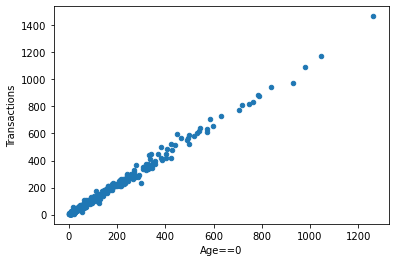

In [6]:
# Scatterplot of births (labelled as 'Transactions'!) by persons with 'Age==0' at the 2016 census
comparison.plot.scatter(y='Transactions',x='Age==0')

In [7]:
# correlation matrix  (although -- the data isn't normally distributed, both positively skewed, so not really a fair comparison)
comparison.corr()

,Age==0,Transactions
Age==0,1.000000,0.996237
Transactions,0.996237,1.000000


In [8]:
comparison.describe()

,Age==0,Transactions
count,436.000000,368.000000
mean,123.747706,164.040761
std,180.232317,211.483230
min,0.000000,5.000000
25%,10.000000,23.000000
50%,51.000000,85.500000
75%,169.750000,227.250000
max,1262.000000,1467.000000


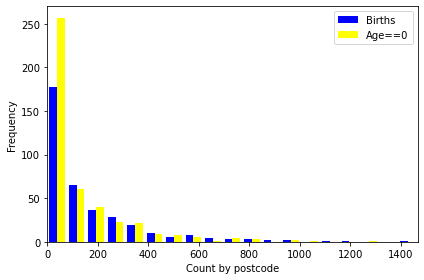

In [9]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['blue','yellow']

bins = np.linspace(0, comparison.max().values[-1], 20)

#plots the histogram
fig, ax = plt.subplots()
ax.hist([comparison['Transactions'],comparison['Age==0']],bins=bins, color=colors, label=['Births','Age==0'])
ax.set_xlim(0,comparison.max().values[-1])
ax.set_xlabel("Count by postcode")
ax.set_ylabel("Frequency")
ax.legend(prop={'size': 10})
plt.tight_layout()

plt.show()

I think the data provides a relatively acceptable approximation.  While the Age==0 data may have some upward bias for postal codes with lower counts (< 200), the trends are broadly similar and there is a strong conceptual match to the data.  I think this suggests that the use of this data for other locations in Australia could provide an adequate approximation of births for use in other analysis.  However, those using the data may wish to conduct further and more detailed validation analyses that take care to account for the skewed distributions of these datasets.